In [1]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.utils import to_categorical

In [2]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]

# training config:
epochs = 50
batch_size = 32

#define paths
covid_path = "originPNG\covidpng"
healthy_path = "originPNG\healthypng"
pneumonia = "originPNG\pneumoniapng"


# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
healthy_files = glob(healthy_path + '/*')
pneumonia_files = glob(pneumonia + '/*')

In [3]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))

print("First 5 Healthy Files: ",healthy_files[0:5])
print("Total Count: ",len(healthy_files))

print("First 5 Pneumonia Files: ",pneumonia_files[0:5])
print("Total Count: ",len(pneumonia_files))

First 5 Covid Files:  ['originPNG\\covidpng\\10-I00381826323-L.dcm.png', 'originPNG\\covidpng\\10-I00381826333.dcm.png', 'originPNG\\covidpng\\10-I00381826341.dcm.png', 'originPNG\\covidpng\\10-I00381826344.dcm.png', 'originPNG\\covidpng\\10-I00381826347.dcm.png']
Total Count:  982
First 5 Healthy Files:  ['originPNG\\healthypng\\1149345 (102).dcm.png', 'originPNG\\healthypng\\1149345 (103).dcm.png', 'originPNG\\healthypng\\1149345 (104).dcm.png', 'originPNG\\healthypng\\1149345 (105).dcm.png', 'originPNG\\healthypng\\1149345 (106).dcm.png']
Total Count:  982
First 5 Pneumonia Files:  ['originPNG\\pneumoniapng\\1-I00381898412.dcm.png', 'originPNG\\pneumoniapng\\1-I00381898412.dcm.png.png', 'originPNG\\pneumoniapng\\1-I00381898414.dcm.png', 'originPNG\\pneumoniapng\\1-I00381898414.dcm.png.png', 'originPNG\\pneumoniapng\\1-I00381898416.dcm.png']
Total Count:  1104


In [4]:
# Fetch Images and Class Labels from Files
covid_labels = []
healthy_labels = []
pneumonia_labels = []

covid_images = []
healthy_images = []
pneumonia_images = []

for i in range(len(covid_files)):
  imag = cv2.imread(covid_files[i]) # read file 
  imag = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB) # arrange format as per kera
  imag = cv2.resize(imag,(224,224)) # resize as per model
  covid_images.append(imag) # append image
  covid_labels.append('CT_COVID') # append class label
for i in range(len(healthy_files)):
  imag = cv2.imread(healthy_files[i])
  imag = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
  imag = cv2.resize(imag,(224,224))
  healthy_images.append(imag)
  healthy_labels.append('CT_Healthy')
for i in range(len(pneumonia_files)):
  imag = cv2.imread(pneumonia_files[i])
  imag = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
  imag = cv2.resize(imag,(224,224))
  pneumonia_images.append(imag)
  pneumonia_labels.append('CT_Pneumonia')

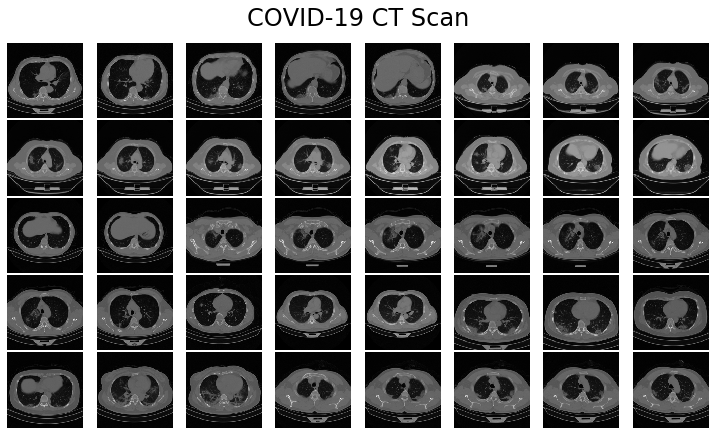

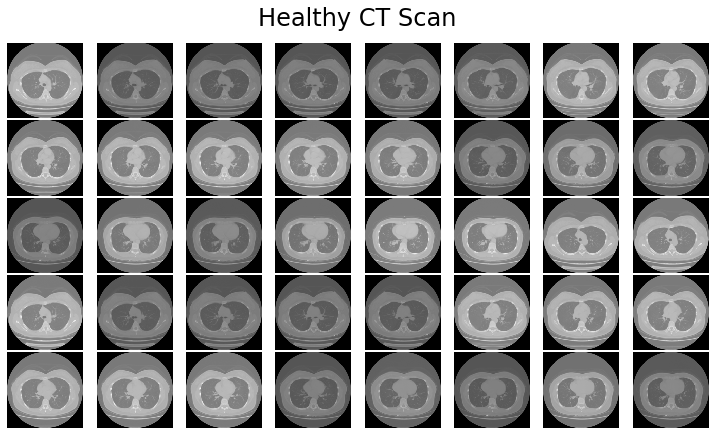

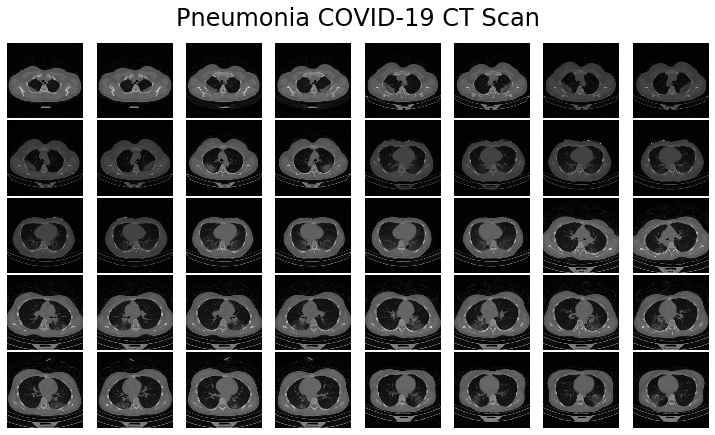

In [6]:
# look at a random image 
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'COVID-19 CT Scan')
plot_images(healthy_images, 'Healthy CT Scan')
plot_images(pneumonia_images, 'Pneumonia COVID-19 CT Scan')

In [7]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
healthy_images = np.array(healthy_images) / 255
pneumonia_images = np.array(pneumonia_images) / 255

In [8]:
# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
healthy_x_train, healthy_x_test, healthy_y_train, healthy_y_test = train_test_split(
    healthy_images, healthy_labels, test_size=0.2)
pneumonia_x_train, pneumonia_x_test, pneumonia_y_train, pneumonia_y_test = train_test_split(
    pneumonia_images, pneumonia_labels, test_size=0.2)


X_train = np.concatenate((healthy_x_train, covid_x_train), axis=0)
X_test = np.concatenate((healthy_x_test, covid_x_test), axis=0)
y_train = np.concatenate((healthy_y_train, covid_y_train), axis=0)
y_test = np.concatenate((healthy_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test) 

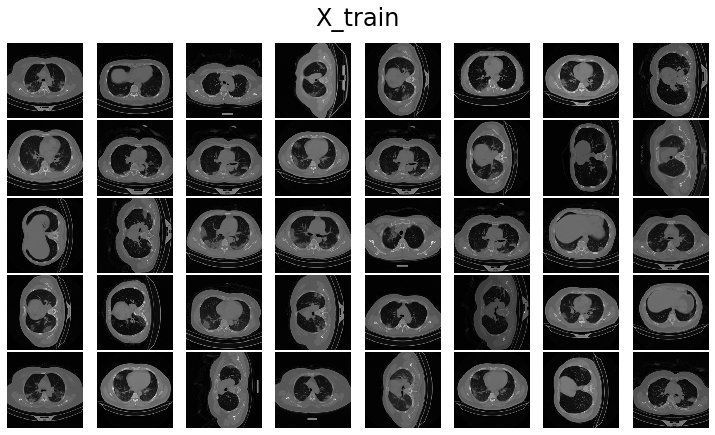

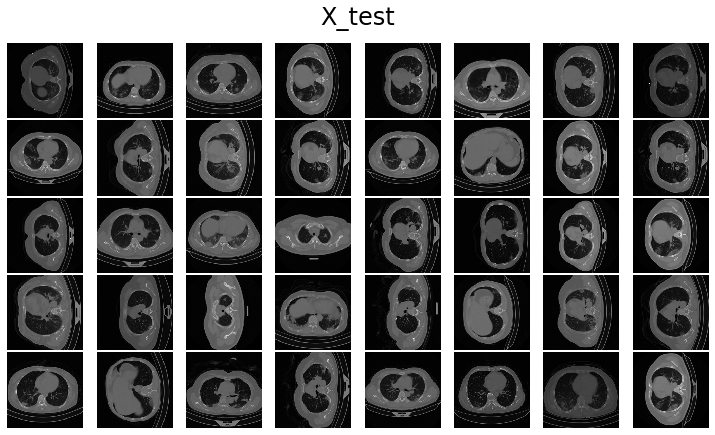

In [9]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

In [10]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Flatten(name="flatten2")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [11]:
# Visualize Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_67 (BatchNo (None, 12, 12, 192)  576         conv2d_67[0][0]                  
__________________________________________________________________________________________________
activation_62 (Activation)      (None, 12, 12, 192)  0           batch_normalization_62[0][0]     
__________________________________________________________________________________________________
activation_67 (Activation)      (None, 12, 12, 192)  0           batch_normalization_67[0][0]     
__________________________________________________________________________________________________
average_pooling2d_6 (AveragePoo (None, 12, 12, 768)  0           mixed6[0][0]                     
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 12, 12, 192)  147456      mixed6[0][0]                     
__________

In [12]:
# image augmentation
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [13]:
# train the model
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/50
49/49 [==============================] - 264s 5s/step - loss: 1.1587 - accuracy: 0.8050 - val_loss: 0.5330 - val_accuracy: 0.9188
Epoch 2/50
49/49 [==============================] - 240s 5s/step - loss: 0.6700 - accuracy: 0.9184 - val_loss: 0.4722 - val_accuracy: 0.9112
Epoch 3/50
49/49 [==============================] - 277s 6s/step - loss: 0.6043 - accuracy: 0.9152 - val_loss: 0.4245 - val_accuracy: 0.9213
Epoch 4/50
49/49 [==============================] - 328s 7s/step - loss: 0.5802 - accuracy: 0.9393 - val_loss: 0.4165 - val_accuracy: 0.9442
Epoch 5/50
49/49 [==============================] - 262s 5s/step - loss: 0.7384 - accuracy: 0.9120 - val_loss: 0.4820 - val_accuracy: 0.9137
Epoch 6/50
49/49 [==============================] - 267s 5s/step - loss: 0.7157 - accuracy: 0.9171 - val_loss: 0.5956 - val_accuracy: 0.9264
Epoch 7/50
49/49 [==============================] - 317s 6s/step - loss: 0.8599 - accuracy: 0.9196 - val_loss: 1.7936 - val_accuracy: 0.8553
Epoch 8/50
49